In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from gplib import TPhotonLib
from photonlib.meta import VoxelMeta

with h5py.File('data/lightLUT_Mod123_06052024.h5', 'r') as f:
    d = f['arr'][:]
    
gplib = TPhotonLib.load("data/plib_2x2_module123_06052024.h5")

[PhotonLib] loading data/plib_2x2_module123_06052024.h5
[PhotonLib] file loaded


In [2]:
# X: x voxels
# Y: y voxels
# Z: z voxels
# C: channels
# T: time steps

shape = X, Y, Z, C, T = d["time_dist"].shape
d_t = d["time_dist"].copy().astype(float)
d_t = d_t / np.clip(d_t.sum(axis=-1, keepdims=True), 1, None)

d_vxyzt = torch.tensor(d["vis"].copy()).unsqueeze(-1) * torch.tensor(d_t)
# (X,Y,Z,C,T) -> (X,Y,Z,T,C)
d_vxyzt = d_vxyzt.permute(0, 1, 2, 4, 3)
# (X,Y,Z,T,C) -> (T,Z,Y,X,C)
d_vxyzt = d_vxyzt.permute(list(range(len(shape)-1))[::-1]+[len(shape)-1])
# (T,Z,Y,X,C) -> (-1, C)
d_vxyzt_rav = d_vxyzt.reshape(-1, C)

print(d_vxyzt.shape)

torch.Size([100, 32, 128, 64, 48])


In [8]:
new_shape = torch.tensor([*gplib.meta.shape, 100])
new_ranges = torch.cat([gplib.meta.ranges, torch.tensor([[-0.5,99.5]])])

meta = VoxelMeta(shape=new_shape, ranges=new_ranges)
meta.shape

tensor([ 32, 128,  64, 100])

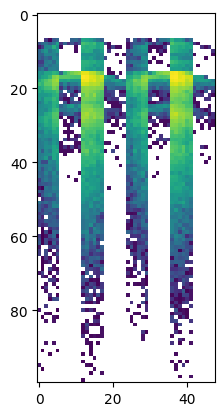

In [35]:
from matplotlib.colors import LogNorm

plt.imshow(d_vxyzt[:,16,64,32,:],norm=LogNorm())
plt.show()

In [39]:
d_vxyzt_rav.shape

torch.Size([26214400, 48])

In [9]:
TPhotonLib.save("data/plib_2x2_module123_06052024_vxyzt48.h5", d_vxyzt_rav, meta)

[PhotonLib] saving to data/plib_2x2_module123_06052024_vxyzt48.h5
[PhotonLib] file saved


In [ ]:
plt.hist(d_vxyzt[d_vxyzt!=0], bins=np.logspace(-8, -3, 100))
plt.yscale("log")
plt.xscale("log")
plt.show()

In [11]:
values = d_vxyzt.reshape(X*Y*Z, -1)
values . shape

torch.Size([262144, 4800])

[PhotonLib] saving to data/plib_2x2_module0_06052024_vxyzt.h5
[PhotonLib] file saved


In [3]:
t_ravel = input["time_dist"].ravel()

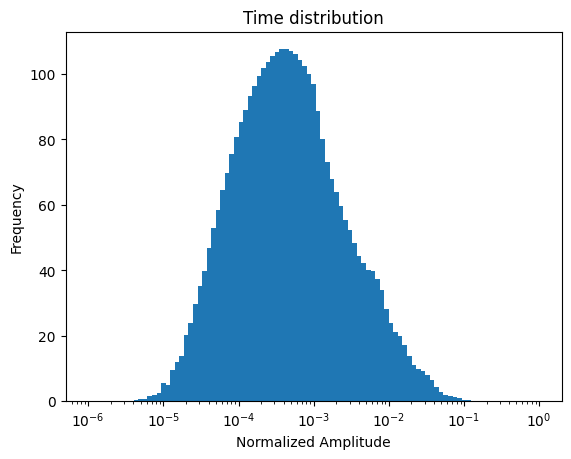

In [235]:
plt.hist(t_ravel, bins=np.logspace(-6, 0, 100), density=True)
plt.xscale('log')
plt.title("Time distribution")
plt.xlabel("Normalized Amplitude")
plt.ylabel("Frequency")
plt.show()

In [61]:
from fast_histogram import histogram1d

v_xyzt
hist = histogram1d(t_ravel, bins=np.logspace(-6, 0, 100))

: 

Dataset shape: torch.Size([64, 128, 32, 48, 100])


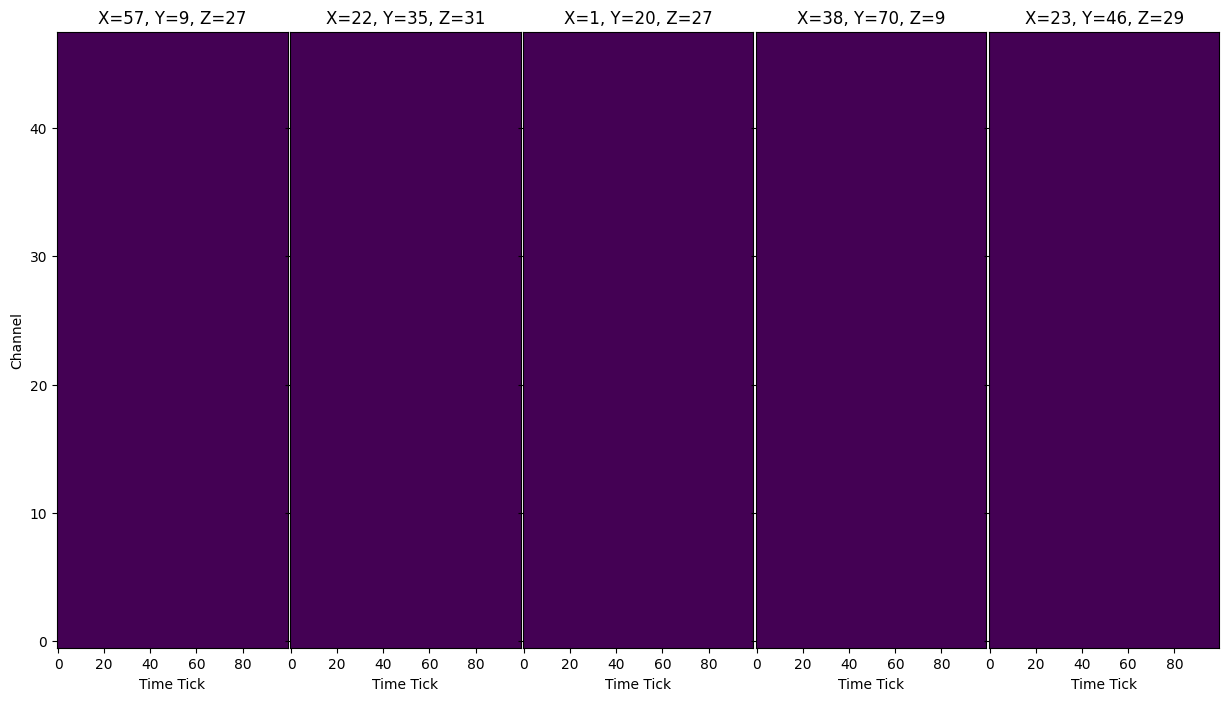

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

data = v_xyzt

X, Y, Z, C, T = data.shape
print(f"Dataset shape: {data.shape}")

# Choose the middle slice for visualization

fig, ax = plt.subplots(1, 5, figsize=(15, 8), sharey=True)
# remove space between subplots
plt.subplots_adjust(wspace=0.01)

for i in range(5):
    currax = ax[i]

    X_slice = np.random.randint(X)
    Y_slice = np.random.randint(Y)
    Z_slice = np.random.randint(Z)

    currax.imshow(
        data[X_slice, Y_slice, Z_slice, :, :],
        cmap="viridis",
        # norm=LogNorm(),
        origin="lower",
        aspect="auto",
    )
    currax.set_title(f"X={X_slice}, Y={Y_slice}, Z={Z_slice}")
    currax.set_xlabel("Time Tick")

ax[0].set_ylabel("Channel")
plt.show()

Dataset shape: (64, 128, 32, 48)


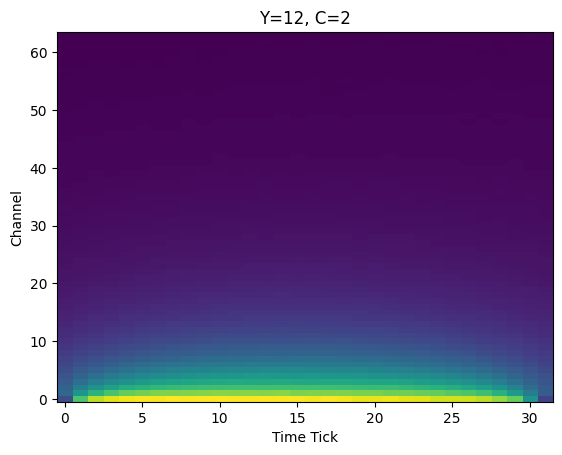

In [52]:
data = d["vis"]

X, Y, Z, C = data.shape
print(f"Dataset shape: {data.shape}")


# X_slice = np.random.randint(X)
# Y_slice = np.random.randint(Y)
# Z_slice = np.random.randint(Z)
Y_slice = int(Y*0.1)
channel = np.random.randint(C)

plt.imshow(
    data[:, Y_slice, :, channel],
    cmap="viridis",
    # norm=LogNorm(),
    origin="lower",
    aspect="auto",
)
plt.title(f"Y={Y_slice}, C={channel}")
plt.xlabel("Time Tick")
plt.ylabel("Channel")
plt.show()

In [6]:
import torch

# (X, Y, Z, C, T) -> (Z*Y*X, C + C*T)


In [7]:
input_tensor = torch.tensor(d['vis']).permute(2,1,0,3)

# Verify the ordering
assert torch.allclose(values2[0, :48], input_tensor[0, 0, 0])
assert torch.allclose(values2[1, :48], input_tensor[1, 0, 0])
assert torch.allclose(values2[Z + 1, :48], input_tensor[1, 1, 0])

In [162]:
output = values.permute(2, 1, 0, 3).reshape(-1, C)

In [165]:
torch.allclose(
    output[1, :48],
    torch.tensor(d["vis"]).permute(2,1,0,3)[0, 0, 0, :].reshape(-1),
)

False

In [130]:
d["vis"].shape

(64, 128, 32, 48)

In [129]:
values.reshape(X * Y * Z, -1)[1, :48]

tensor([1.0568e-03, 1.0568e-03, 6.7392e-05, 6.7392e-05, 2.7144e-05, 2.7144e-05,
        1.6380e-06, 1.6380e-06, 1.2090e-06, 1.1700e-06, 1.0140e-06, 1.4040e-06,
        3.0810e-06, 3.0810e-06, 2.3790e-06, 2.3790e-06, 1.4430e-06, 1.4430e-06,
        3.9000e-08, 1.5600e-07, 1.9500e-07, 1.1700e-07, 2.3400e-07, 7.8000e-08,
        2.3907e-05, 2.3907e-05, 2.5857e-05, 2.5857e-05, 2.0982e-05, 2.0982e-05,
        2.4180e-06, 2.5350e-06, 2.7690e-06, 2.3400e-06, 2.7690e-06, 2.4180e-06,
        1.1583e-05, 1.1583e-05, 6.5520e-06, 6.5520e-06, 4.8360e-06, 4.8360e-06,
        4.2900e-07, 5.8500e-07, 2.3400e-07, 3.1200e-07, 2.3400e-07, 3.5100e-07])

In [122]:
plib.meta.voxel_to_coord(0)

tensor([-14.6632, -62.6007, -30.5304])

In [124]:
plib.meta.voxel_to_coord(32)

tensor([-14.6632, -61.6148, -30.5304])

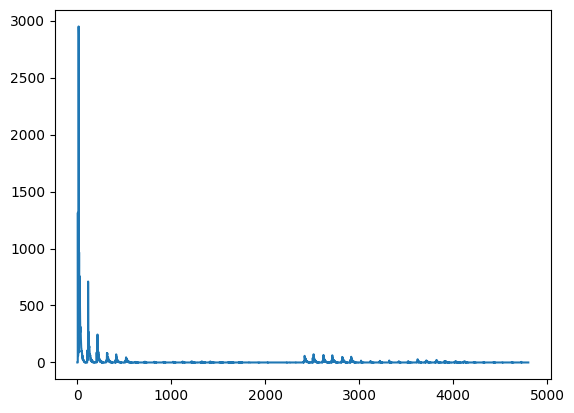

In [24]:
plt.plot(total[0,48:].ravel().numpy());

In [48]:
plib.meta.voxel_to_idx(32)

tensor([0, 1, 0])

In [47]:
plib.meta.shape

tensor([ 32, 128,  64])

/tmp/ipykernel_1245252/2088313406.py:8: RuntimeWarning: divide by zero encountered in log10
  counts = histogram1d(np.log10(reshaped[:,::C].numpy()), bins=100, range=(-9, 0))


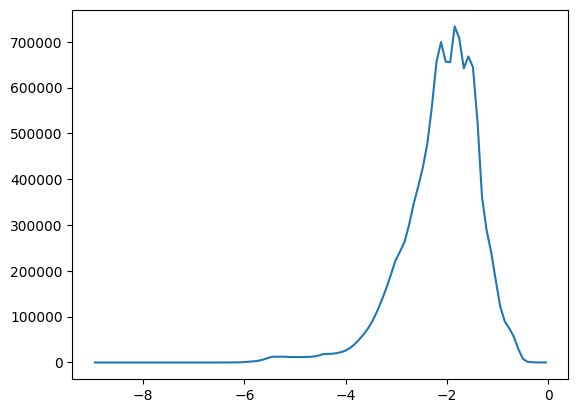

In [18]:
# Total shape: (X * Y * Z, C * T + C)
# 0th dim should be the number of samples
# 1st dim should be the number of features in order [vis0, ..., vis47, t^0_0, ..., t^0_99, t^1_0, ..., t^1_99, ..., t^47_99]


from fast_histogram import histogram1d
counts = histogram1d(np.log10(reshaped[:,::C].numpy()), bins=100, range=(-9, 0))
edges  = np.log10(np.logspace(-9, 0, 101))
centers = (edges[1:] + edges[:-1]) / 2
plt.plot(centers, counts)